<h1><center> Análise de pellets plásticos como ferramenta para o estudo de permanência de microplásticos em praias arenosas. </center></h1>

Juana Gerevini Bozzetto

## 03. Filtrando as Imagens

- Trabalhar com apenas uma imagem, tentado distrinchar o código para ela
- 1 imagens utilizadas: pellet amarelo claro
- Retirar o fundo preto da imagem, mantendo a área de interesse
- Opções para remoção do fundo:

> **1) Florian's Blog** - https://flothesof.github.io/removing-background-scikit-image.html --> não funciona pq rotina para imagem pb 

> **2) Remove background colour from image using Python/PIL** - https://stackoverflow.com/questions/21217384/remove-background-colour-from-image-using-python-pil

> **3) Remove background with cv2** - (não lembro de onde tirei hihi)

> **4) Regional Maxima** - https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html#sphx-glr-auto-examples-color-exposure-plot-regional-maxima-py

> **5) Retirei o fundo com um site** - https://www.remove.bg/pt-br


In [2]:
# --- Bibliotecas utilizadas na rotina ---#

import os

import matplotlib.pyplot as plt
import numpy as np
import skimage

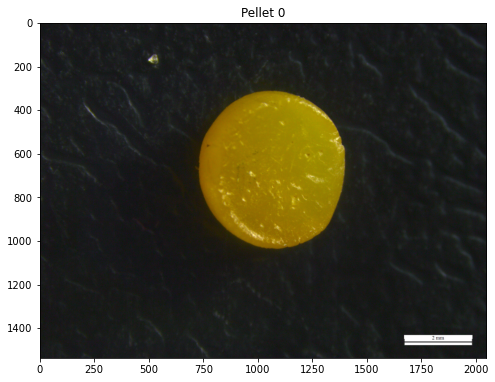

Tamanho da imagem: (1536, 2048, 3)
Tipo de imagem: uint8


In [3]:
# --- Abrindo o arquivo jpg ---#
from skimage import io  # io é parte do skimage

# --- Imagem para teste ---#

# Pellet 0: Pellet Amarelo Claro
pellet_a = io.imread("fotos_pellets_cp/cl1_p1_psul_deixa1_g0005.jpg")


# --- Mostrar Imagens ---#
plt.figure(figsize=(8, 8))  # definindo tamanho da imagem
plt.imshow(pellet_a)
plt.title("Pellet 0")
plt.show()

print("Tamanho da imagem: {}".format(pellet_a.shape))
print("Tipo de imagem: {}".format(pellet_a.dtype))

# imagens coloridas possuem .shape matriz 3D [altura, largura, cor (3)]

In [4]:
# TENTATIVA 1 - OPÇÃO A - FROLIAN'S BLOG

# rotina de imagem pb, não funciona com as imagens que temos que são coloridas

-1

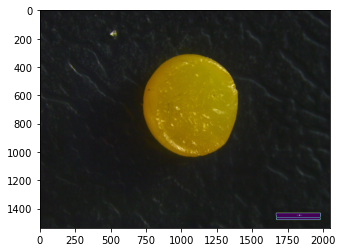

In [5]:
# TENTATIVA 2 - ????

import cv2
import numpy as np

# load image
img = pellet_a

# convert to graky
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
# use borderconstant of black since foreground touches the edges
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=2, sigmaY=2, borderType=cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2 * (mask.astype(np.float32)) - 255.0).clip(0, 255).astype(np.uint8)

# put mask into alpha channel
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# save resulting masked image
cv2.imwrite(
    "fotos_pellets_cp/rotina_03_tentativa2.png",
    result,
)

# display result, though it won't show transparency
plt.imshow(img)
plt.imshow(gray)
plt.imshow(mask)
plt.imshow(result)
cv2.waitKey(1)

In [4]:
# TENTATIVA 3 - Python/PIL

import numpy as np
from PIL import Image

im = Image.open("fotos_pellets_cp/cl1_p1_psul_deixa1_g0005.jpg")
im = im.convert("RGBA")
data = np.array(im)
im_color = im.getpixel(
    (10, 15)
)  # pega o pixel de determinadas coordenadas, tentar achar um jeito de pegar tudo (?)
print(im_color)

im_color2 = list(im.getdata())
print(im_color2)  # lista de pixel das imagens, mas nao carregou aqui pq:

"""IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)
"""

# just use the rgb values for comparison
rgb = data[:, :, :3]
color = list(im_color[:3])
print(color)  # Original value
black = [0, 0, 0, 255]
white = [255, 255, 255, 255]
mask = np.all(rgb == color, axis=-1)
# change all pixels that match color to white
data[mask] = white

# change all pixels that don't match color to black
##data[np.logical_not(mask)] = black
new_im = Image.fromarray(data)
new_im.save("fotos_pellets_cp/rotina_03_tentativa3.png")

(16, 25, 24, 255)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# TENTATIVA 4 - REGIONAL MAXIMA

"""First we try reconstruction by dilation starting at the edges of the image. We
initialize a seed image to the minimum intensity of the image, and set its
border to be the pixel values in the original image. These maximal pixels will
get dilated in order to reconstruct the background image.) """

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage import data, img_as_float

# Convert to float: Important for subtraction later which won't work with uint8
from skimage.io import imread
from skimage.morphology import reconstruction

sk_image = imread("fotos_pellets_cp/cl1_p1_psul_deixa1_g0005.jpg")
image = img_as_float(sk_image)
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method="dilation")

images = [image, dilated]

"""Subtracting the dilated image leaves an image with just the coins and a
flat, black background, as shown below."""

fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=1, ncols=3, figsize=(8, 2.5), sharex=True, sharey=True
)

ax0.imshow(image, cmap="gray")
ax0.set_title("original image")
ax0.axis("off")

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap="gray")
ax1.set_title("dilated")
ax1.axis("off")

ax2.imshow(image - dilated, cmap="gray")
ax2.set_title("image - dilated")
ax2.axis("off")

fig.tight_layout()

"""Although the features (i.e. the coins) are clearly isolated, the coins
surrounded by a bright background in the original image are dimmer in the
subtracted image. We can attempt to correct this using a different seed
image.

Instead of creating a seed image with maxima along the image border, we can
use the features of the image itself to seed the reconstruction process.
Here, the seed image is the original image minus a fixed value, ``h``."""

h = 0.4
seed = image - h
dilated = reconstruction(seed, mask, method="dilation")
hdome = image - dilated

"""To get a feel for the reconstruction process, we plot the intensity of the
mask, seed, and dilated images along a slice of the image (indicated by red
line)."""

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 197

ax0.plot(mask[yslice], "0.5", label="mask")
ax0.plot(seed[yslice], "k", label="seed")
ax0.plot(dilated[yslice], "r", label="dilated")
ax0.set_ylim(-0.2, 2)
ax0.set_title("image slice")
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap="gray")
ax1.axhline(yslice, color="r", alpha=0.4)
ax1.set_title("dilated")
ax1.axis("off")

ax2.imshow(hdome, cmap="gray")
ax2.axhline(yslice, color="r", alpha=0.4)
ax2.set_title("image - dilated")
ax2.axis("off")

fig.tight_layout()
plt.show()

"""As you can see in the image slice, each coin is given a different baseline
intensity in the reconstructed image; this is because we used the local
intensity (shifted by ``h``) as a seed value. As a result, the coins in the
subtracted image have similar pixel intensities. The final result is known
as the h-dome of an image since this tends to isolate regional maxima of
height ``h``. This operation is particularly useful when your images are
unevenly illuminated. """

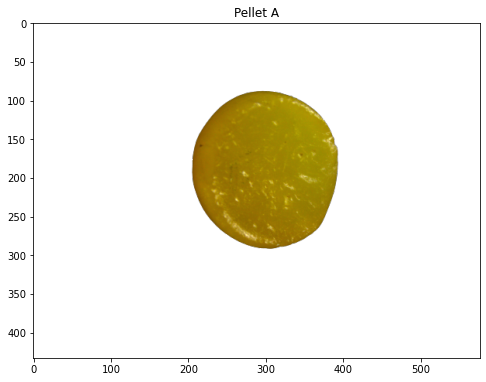

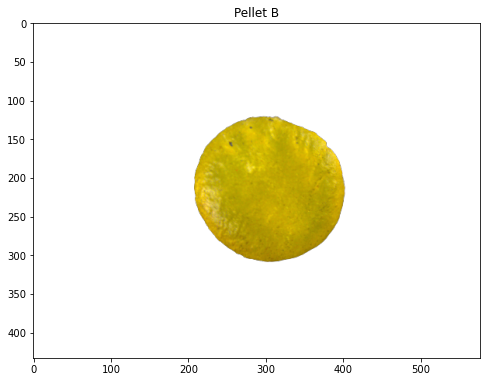

In [8]:
# TENTATIVA 5 - SITE REMOVE BG

import matplotlib.pyplot as plt
from skimage import io

# Diminui a qualidade da imagem, fiz o teste pra tentar colocar nos histogramas e ver o que acontecia

pellet_5a = io.imread("fotos_pellets_cp/rotina_03_tentativa5a.png")
pellet_5b = io.imread("fotos_pellets_cp/rotina_03_tentativa5b.png")

# --- Mostrar Imagens ---#
plt.figure(figsize=(8, 8))  # definindo tamanho da imagem
plt.imshow(pellet_5a)
plt.title("Pellet A")
plt.show()

plt.figure(figsize=(8, 8))  # definindo tamanho da imagem
plt.imshow(pellet_5b)
plt.title("Pellet B")
plt.show()